# Unit 5 - Financial Planning


In [3]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [4]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [5]:
# Set current amount of crypto assets
# Assume the following amount of crypto assets: 1.2 BTC and 5.3 ETH.
my_btc = 1.2
my_eth = 5.3

In [6]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [7]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $38019.60
The current value of your 5.3 ETH is $5648.42


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [8]:
# Current amount of shares
# YOUR CODE HERE!
# Assume the following amount of shares in stocks and bonds: 50 SPY (stocks) and 200 AGG (bonds).
my_agg = 200
my_spy = 50

In [16]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='v2')

In [22]:
# Format current date as ISO format
today = pd.Timestamp("2020-01-03", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
dt_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
dt_portfolio

AGG                                        SPY  \
                             open    high       low   close   volume    open   
time                                                                           
2020-01-03 00:00:00-05:00  112.89  113.05  112.7814  113.02  3465113  321.16   

                                                            
                             high    low   close    volume  
time                                                        
2020-01-03 00:00:00-05:00  323.64  321.1  322.44  58408809

In [38]:
# Pick AGG and SPY close prices
df_closing_prices = pd.DataFrame()

df_closing_prices['AGG'] = dt_portfolio['AGG']['close']
df_closing_prices['SPY'] = dt_portfolio['SPY']['close']

df_closing_prices.index = df_closing_prices.index.date

agg_close_price = df_closing_prices.iloc[0,0]
spy_close_price = df_closing_prices.iloc[0,1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $113.02
Current SPY closing price: $322.44


In [39]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $16122.00
The current value of your 200 AGG shares is $22604.00


### Savings Health Analysis

In [50]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
total_crypto = my_btc_value + my_eth_value
total_shares = my_spy_value + my_agg_value

saving = { 'type': ['crypto', 'shares'],  
          'amount': [total_crypto, total_shares]
         }

df_savings = pd.DataFrame(saving, columns = ['type','amount']).set_index('type')

# Display savings DataFrame
display(df_savings)

,amount
type,
crypto,43668.022
shares,38726.000


<AxesSubplot:title={'center':'Composition of Pesronal Savins'}, ylabel='amount'>

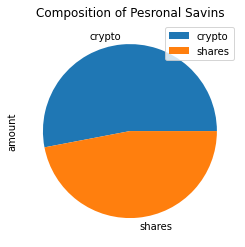

In [53]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Pesronal Savins")

In [69]:
# Set ideal emergency fund
emergency_fund =  monthly_income * 3

# Calculate total amount of savings
total_savings = float(df_savings.sum())

# Validate saving health
if total_savings > emergency_fund:
    print(f"Your current savings value of ${total_savings:0.2f} is greater than the recommended emergency savings amount of ${emergency_fund} congratulations!")
elif total_savings == emergency_fund:
    print(f"Your current savings value of ${total_savings:0.2f} is equal to the recommended emergency savings amount of ${emergency_fund} good job!")
else:
    print(f"Your current savings value of ${total_savings:0.2f} is less than the recommended emergency savings amount of ${emergency_fund} keep saving!")
    


Your current savings value of $82394.02 is greater than the recommended emergency savings amount of $36000 congratulations!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [70]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-01-03', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-03', tz='America/New_York').isoformat()

In [73]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
df_stock_data.head()

AGG                                        SPY  \
                             open    high     low   close     volume    open   
time                                                                           
2016-01-04 00:00:00-05:00  108.09  108.29  107.93  107.99  3427605.0  200.50   
2016-01-05 00:00:00-05:00  107.87  108.12  107.87  108.02  2564401.0  201.40   
2016-01-06 00:00:00-05:00  108.34  108.46  108.22  108.43  2674241.0  198.34   
2016-01-07 00:00:00-05:00  108.40  108.47  108.21  108.43  2267940.0  195.33   
2016-01-08 00:00:00-05:00  108.57  108.71  108.35  108.67  3775874.0  195.19   

                                                              
                             high     low   close     volume  
time                                                          
2016-01-04 00:00:00-05:00  201.03  198.59  200.99  151908002  
2016-01-05 00:00:00-05:00  201.90  200.05  201.43   90242524  
2016-01-06 00:00:00-05:00  200.06  197.60  198.79  118917648  
2016-01-07 00:00:00-05:00  198.82  193.59  194.01  174230042  
2016-01-08 00:00:00-05:00  195.85  191.58  191.89  157703921

In [74]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [77]:
# Printing the simulation input data
MC_thirtyyear.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2016-01-04 00:00:00-05:00  108.09  108.29  107.93  107.99  3427605.0   
2016-01-05 00:00:00-05:00  107.87  108.12  107.87  108.02  2564401.0   
2016-01-06 00:00:00-05:00  108.34  108.46  108.22  108.43  2674241.0   
2016-01-07 00:00:00-05:00  108.40  108.47  108.21  108.43  2267940.0   
2016-01-08 00:00:00-05:00  108.57  108.71  108.35  108.67  3775874.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-01-04 00:00:00-05:00          NaN  200.50  201.03  198.59  200.99   
2016-01-05 00:00:00-05:00     0.000278  201.40  201.90  200.05  201.43   
2016-01-06 00:00:00-05:00     0.003796  198.34  200.06  197.60  198.79   
2016-01-07 00:00:00-05:00     0.000000  195.33  198.82  193.59  194.01   
2016-01-08 00:00:00-05:00     0.002213  195.19  195.85  191.58  191.89   

                                                   
                              volume daily_return  
time                                               
2016-01-04 00:00:00-05:00  151908002          NaN  
2016-01-05 00:00:00-05:00   90242524     0.002189  
2016-01-06 00:00:00-05:00  118917648    -0.013106  
2016-01-07 00:00:00-05:00  174230042    -0.024045  
2016-01-08 00:00:00-05:00  157703921    -0.010927

In [78]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997007,1.004842,1.004909,0.999843,0.998503,0.991948,1.005652,0.998426,1.004879,0.998060,...,1.004230,1.004616,1.005887,0.997727,1.004651,0.994472,1.001660,0.990200,0.996048,1.002739
2,1.003529,1.009087,0.999404,1.004211,1.003003,0.992293,1.001407,0.999991,1.010660,1.004780,...,1.003430,1.009527,0.999804,0.993234,1.008138,0.988415,0.998016,0.990226,1.001671,1.005173
3,1.004542,1.016272,0.996696,1.000638,0.995593,0.989935,1.003510,0.997805,1.015263,1.006758,...,0.999190,1.007285,0.994802,0.998566,1.012129,0.988923,0.996976,0.996634,1.002419,1.010212
4,1.014154,1.015293,0.996484,1.003307,1.001844,0.991006,1.003666,1.003812,1.010884,1.008706,...,0.998323,1.008836,0.991816,1.006866,1.015509,0.985022,1.004220,0.995929,0.994768,1.004155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.665734,7.777516,3.040501,5.090413,6.151468,10.313348,5.292487,3.135867,7.677567,6.567480,...,7.949312,8.357768,6.708626,4.592041,13.398572,4.084819,6.728619,7.806271,5.675462,7.620845
7557,6.638275,7.787231,3.045555,5.090703,6.125478,10.353163,5.224045,3.138012,7.688930,6.615577,...,7.921336,8.351793,6.700230,4.599475,13.397183,4.067726,6.732049,7.850771,5.695781,7.552099
7558,6.639252,7.773695,3.046307,5.086269,6.145681,10.320043,5.259611,3.132331,7.710821,6.645235,...,7.889866,8.325915,6.690494,4.622663,13.541659,4.076685,6.727098,7.870661,5.668313,7.556989
7559,6.677175,7.781095,3.030373,5.121842,6.149309,10.229094,5.242246,3.108851,7.733668,6.671583,...,7.887963,8.365216,6.661739,4.610373,13.439627,4.098859,6.719361,7.899741,5.676640,7.516815


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

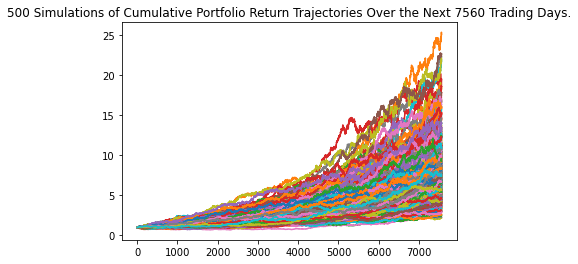

In [79]:
# Plot simulation outcomes
MC_thirtyyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

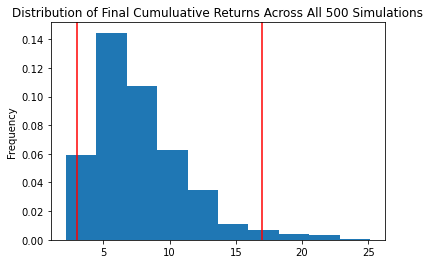

In [80]:
# Plot probability distribution and confidence intervals
MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [81]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              7.849046
std               3.574542
min               2.171566
25%               5.391763
50%               7.045920
75%               9.611506
max              25.140819
95% CI Lower      3.042728
95% CI Upper     17.011699
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [85]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $60854.55 and $340233.98


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [86]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $91281.83 and $510350.98


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [95]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [96]:
MC_fiveyear.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2016-01-04 00:00:00-05:00  108.09  108.29  107.93  107.99  3427605.0   
2016-01-05 00:00:00-05:00  107.87  108.12  107.87  108.02  2564401.0   
2016-01-06 00:00:00-05:00  108.34  108.46  108.22  108.43  2674241.0   
2016-01-07 00:00:00-05:00  108.40  108.47  108.21  108.43  2267940.0   
2016-01-08 00:00:00-05:00  108.57  108.71  108.35  108.67  3775874.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-01-04 00:00:00-05:00          NaN  200.50  201.03  198.59  200.99   
2016-01-05 00:00:00-05:00     0.000278  201.40  201.90  200.05  201.43   
2016-01-06 00:00:00-05:00     0.003796  198.34  200.06  197.60  198.79   
2016-01-07 00:00:00-05:00     0.000000  195.33  198.82  193.59  194.01   
2016-01-08 00:00:00-05:00     0.002213  195.19  195.85  191.58  191.89   

                                                   
                              volume daily_return  
time                                               
2016-01-04 00:00:00-05:00  151908002          NaN  
2016-01-05 00:00:00-05:00   90242524     0.002189  
2016-01-06 00:00:00-05:00  118917648    -0.013106  
2016-01-07 00:00:00-05:00  174230042    -0.024045  
2016-01-08 00:00:00-05:00  157703921    -0.010927

In [97]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996356,0.993375,0.999876,1.001527,0.994431,1.008408,1.006747,1.005377,1.000855,1.009126,...,1.003935,1.001108,0.995984,0.991060,0.998525,0.991756,1.001107,0.992710,1.008034,0.997558
2,0.991255,0.995198,0.995013,1.002156,0.991690,1.025176,1.000022,1.008044,1.000845,1.004493,...,1.010512,1.003399,0.997593,0.997275,0.996423,0.994077,0.999648,0.994980,1.005534,0.995970
3,0.984591,0.990906,0.999213,0.997343,0.988838,1.017876,1.002887,1.007042,1.009244,1.007743,...,1.004354,0.996637,0.994265,0.987371,0.990058,0.993705,1.007569,0.996596,1.006181,0.993724
4,0.982688,0.998405,1.000081,0.999174,0.987480,1.019040,1.007286,1.004205,1.007361,1.005381,...,1.008172,1.003906,0.995372,0.979252,0.987055,0.992954,1.006701,0.999350,0.999907,0.993022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.402204,1.217078,1.268361,1.398429,1.074207,1.237381,1.077194,1.243415,1.264170,1.579011,...,1.634709,1.385342,1.125104,1.370657,1.148353,1.505746,1.233701,0.984063,1.659135,1.391983
1257,1.402257,1.219661,1.269616,1.393023,1.077400,1.229060,1.074843,1.240425,1.257448,1.575345,...,1.641724,1.395828,1.127799,1.374534,1.151517,1.504459,1.236498,0.988111,1.666043,1.394945
1258,1.398608,1.218289,1.263173,1.377636,1.079009,1.238994,1.070905,1.249839,1.248075,1.575133,...,1.663091,1.394610,1.130705,1.383095,1.149723,1.506485,1.239387,0.987616,1.665555,1.403653
1259,1.401309,1.209077,1.260845,1.386880,1.078692,1.242395,1.075007,1.251149,1.244213,1.585365,...,1.643940,1.395999,1.131071,1.381029,1.157466,1.508238,1.244217,0.987700,1.667811,1.404128


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

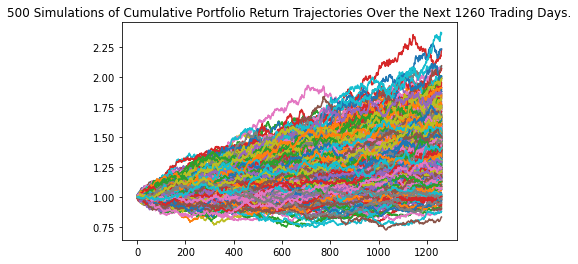

In [98]:
# Plot simulation outcomes
MC_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

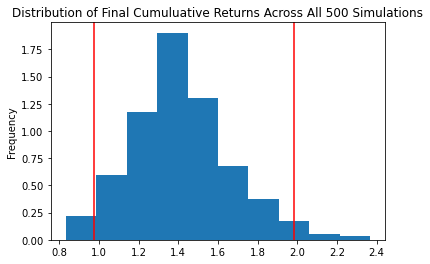

In [99]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

In [100]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              1.413706
std               0.249803
min               0.832712
25%               1.244201
50%               1.394449
75%               1.551839
max               2.366775
95% CI Lower      0.975663
95% CI Upper      1.982130
Name: 1260, dtype: float64


In [101]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl[8]*initial_investment,2)
ci_upper_five = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $58539.78 and $118927.82


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997817,0.998428,1.000816,1.000202,1.002120,0.998788,1.004226,1.004250,1.001431,1.000740,...,0.995519,1.001253,1.000492,0.994026,1.006129,1.002356,1.005233,0.999769,1.002106,1.003746
2,0.994703,0.996223,1.001987,0.998816,1.002372,0.996708,1.009074,1.006986,1.006219,0.995591,...,0.991815,1.001091,1.003774,0.989341,1.007530,1.009809,1.007273,0.999666,1.006340,0.998303
3,0.994115,0.993375,0.992622,1.001069,0.999700,1.000123,1.011610,1.009254,1.012194,0.998619,...,0.992699,1.003085,1.005997,0.991536,1.004239,1.010765,1.009501,0.999652,1.011737,0.998762
4,0.999040,0.997821,0.992272,0.999767,1.000459,1.006178,1.008906,1.009897,1.014282,0.995619,...,0.997683,1.007825,1.007858,0.991188,1.009171,1.009303,1.008223,1.003270,1.014350,1.001691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.164254,1.246948,1.441080,1.685210,1.702114,1.474774,1.535126,1.288182,1.138653,1.500977,...,1.367442,1.357662,1.661583,1.348599,1.649220,1.782632,1.450872,1.701338,1.199957,1.171159
2517,2.169555,1.246315,1.436260,1.685058,1.697652,1.479128,1.536203,1.288485,1.144082,1.498097,...,1.366833,1.360457,1.672969,1.351751,1.646287,1.781356,1.459438,1.695322,1.197466,1.171882
2518,2.169089,1.243387,1.426446,1.685480,1.714264,1.479079,1.537777,1.289258,1.140795,1.496271,...,1.368088,1.357853,1.662915,1.354957,1.637911,1.781046,1.451367,1.695901,1.201111,1.172847
2519,2.170695,1.238881,1.419187,1.670521,1.720418,1.478161,1.544292,1.296500,1.137510,1.499085,...,1.370125,1.359697,1.664317,1.352170,1.633762,1.778638,1.443413,1.699061,1.191529,1.166331


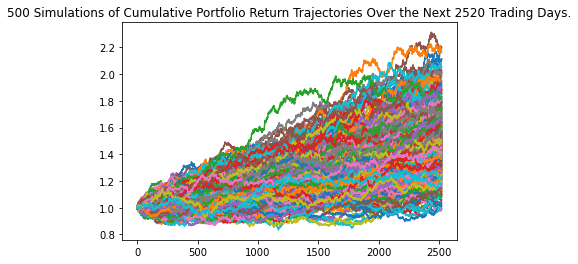

In [32]:
# Plot simulation outcomes
# YOUR CODE HERE!

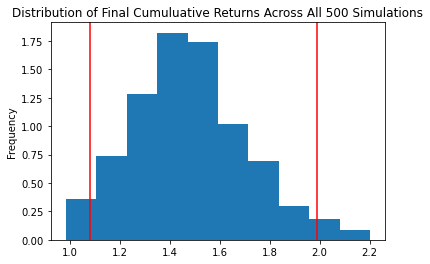

In [33]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.477364
std               0.230147
min               0.984413
25%               1.319127
50%               1.468676
75%               1.613270
max               2.202006
95% CI Lower      1.083048
95% CI Upper      1.990417
Name: 2520, dtype: float64


In [35]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 30 years will end within in the range of $64982.9 and $119425.0
